In [31]:
#Libraries
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import VotingClassifier
import umap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.python.keras.layers import Dropout
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [32]:
df = pd.read_csv('smmh.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['age'] = df['age'].astype(int)
df['hour_of_day'] = df['timestamp'].dt.hour
df['hrs_from_midnight'] = df['hour_of_day'].apply(lambda x: min(x, 24 - x))

platforms_split = df['platform'].str.get_dummies(sep=', ')
platforms_split['platform_count'] = platforms_split.sum(axis=1)
df = pd.concat([df, platforms_split], axis=1)
df.drop(['platform', 'occupation', 'organization', 'use_social_media'], axis=1, inplace=True)

df.head()

,timestamp,age,gender,relationship,avg_time,purposeless_sm_use,distracted_sm_while_busy,restless_without_sm_use,normal_distracted_level,normal_bothered_by_worries,...,Discord,Facebook,Instagram,Pinterest,Reddit,Snapchat,TikTok,Twitter,YouTube,platform_count
0,2022-04-18 19:18:00,21,Male,In a relationship,2-3 hours,5,3,2,5,2,...,1,1,1,0,1,0,0,1,1,6
1,2022-04-18 19:19:00,21,Female,Single,5+ hours,4,3,2,4,5,...,1,1,1,0,1,0,0,1,1,6
2,2022-04-18 19:25:00,21,Female,Single,3-4 hours,3,2,1,2,5,...,0,1,1,1,0,0,0,0,1,4
3,2022-04-18 19:29:00,21,Female,Single,5+ hours,4,2,1,3,5,...,0,1,1,0,0,0,0,0,0,2
4,2022-04-18 19:33:00,21,Female,Single,2-3 hours,3,5,4,4,5,...,0,1,1,0,0,0,0,0,1,3


We're going to take this data and try to predict people being at risk of low, medium, or high depression frequency

In [33]:
#Depression frequency
bins = [0, 2, 4, 6]  # Adjust bins based on distribution
labels = ['Low', 'Medium', 'High']
df['depressed_category'] = pd.cut(df['depressed_frequency'], bins=bins, labels=labels)

In [34]:
# Normalize and group genders
df['gender'] = df['gender'].str.strip().str.title()  # Normalize text
df['gender'] = df['gender'].replace({
    'Male': 'Male',
    'Female': 'Female',
    'Nonbinary': 'Other',
    'Non-Binary': 'Other',
    'Nb': 'Other',
    'Non Binary': 'Other',
    'Unsure': 'Other',
    'Trans': 'Other',
    'There Are Others???': 'Other'
})

import re

# Define a function to extract the lower bound
def extract_lower_bound(time_str):
    match = re.match(r'(\d+)', time_str)  # Match the first number in the string
    return int(match.group(1)) if match else 0  # Return 0 if no match (for safety)

# Apply the transformation
df['avg_time'] = df['avg_time'].apply(extract_lower_bound)

In [35]:
df_encoded = pd.get_dummies(df, columns=['gender', 'relationship'], drop_first=True, dtype=int)
X = df_encoded.drop(columns=['depressed_frequency', 'depressed_category', 'timestamp','purposeless_sm_use',
       'sleep_issues', 'Facebook', 'Instagram', 'Snapchat', 'TikTok', 'Twitter', 'YouTube' ])
y = df_encoded['depressed_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=486)

In [36]:
rf = RandomForestClassifier(random_state=486)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.44      0.59        18
         Low       0.69      0.69      0.69        29
      Medium       0.68      0.80      0.73        50

    accuracy                           0.70        97
   macro avg       0.75      0.64      0.67        97
weighted avg       0.72      0.70      0.69        97



In [37]:
log_reg = LogisticRegression(max_iter=1000, random_state=486)

# Fit the model
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

        High       0.41      0.39      0.40        18
         Low       0.70      0.66      0.68        29
      Medium       0.64      0.68      0.66        50

    accuracy                           0.62        97
   macro avg       0.59      0.57      0.58        97
weighted avg       0.62      0.62      0.62        97



In [38]:
svm = SVC(kernel='linear', random_state=486)

# Fit the model
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Classification Report:
              precision    recall  f1-score   support

        High       0.60      0.17      0.26        18
         Low       0.68      0.66      0.67        29
      Medium       0.62      0.80      0.70        50

    accuracy                           0.64        97
   macro avg       0.63      0.54      0.54        97
weighted avg       0.64      0.64      0.61        97



In [39]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the model
knn.fit(X_train, y_train)

# Predict and evaluate
X_test = np.ascontiguousarray(X_test)
y_pred_knn = knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))


KNN Classification Report:
              precision    recall  f1-score   support

        High       0.38      0.44      0.41        18
         Low       0.64      0.62      0.63        29
      Medium       0.58      0.56      0.57        50

    accuracy                           0.56        97
   macro avg       0.54      0.54      0.54        97
weighted avg       0.56      0.56      0.56        97



C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


The ensemble method was limited, but comparable to the Random Forest Classifier

In [44]:
# Define the ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('knn', knn),
        ('log_reg', log_reg)
    ],
    voting='hard'  # Use soft voting
)

# Fit the ensemble on training data
ensemble.fit(X_train, y_train)

# Predict with the ensemble
final_preds = ensemble.predict(X_test)

C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [45]:
print("Ensemble Classification Report:")
print(classification_report(y_test, final_preds))

Ensemble Classification Report:
              precision    recall  f1-score   support

        High       0.47      0.39      0.42        18
         Low       0.69      0.62      0.65        29
      Medium       0.62      0.70      0.66        50

    accuracy                           0.62        97
   macro avg       0.59      0.57      0.58        97
weighted avg       0.62      0.62      0.61        97



In [52]:
# Initialize stratified k-fold
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=486)

# Example classifier
clf = RandomForestClassifier(random_state=486)

# Perform stratified k-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

Cross-Validation Accuracy Scores: [0.63934426 0.58333333 0.61666667 0.68333333 0.53333333 0.6
 0.6        0.5       ]
Mean Accuracy: 0.5945, Std Dev: 0.0539


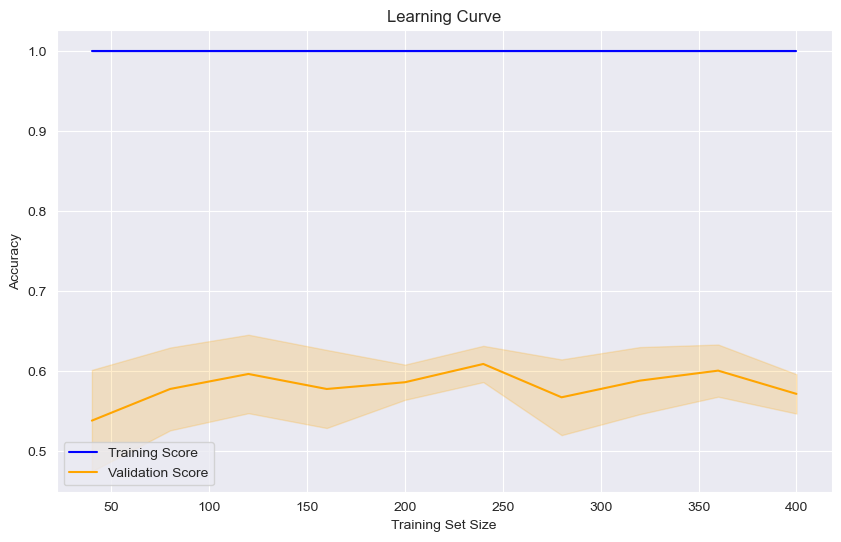

In [43]:
from sklearn.model_selection import learning_curve

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    clf, X, y, cv=skf, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=486
)

# Calculate mean and standard deviation for training and validation scores
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='Validation Score', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='orange', alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

We'll now move on to some cluster analysis and anomoly detection

C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

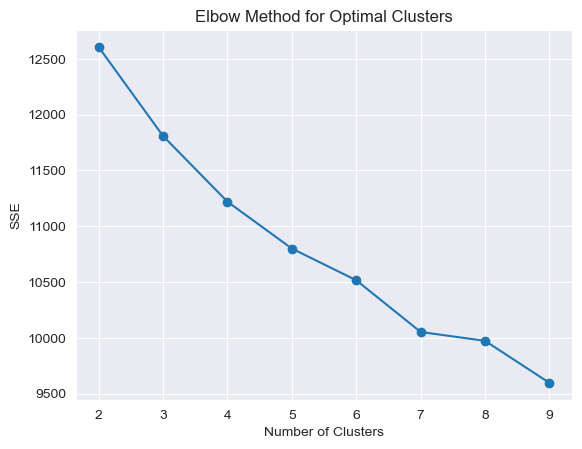

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster Analysis
# Find optimal number of clusters
sse = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=486)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot elbow method
plt.plot(range_n_clusters, sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method for Optimal Clusters")
plt.show()

In [13]:
# Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=486)  # Adjust clusters based on elbow method
df_encoded['cluster'] = kmeans.fit_predict(X_scaled)

# Anomaly Detection
# Isolation Forest
iso_forest = IsolationForest(random_state=486)
df_encoded['anomaly_isolation'] = iso_forest.fit_predict(X_scaled)

# Local Outlier Factor
lof = LocalOutlierFactor()
df_encoded['anomaly_lof'] = lof.fit_predict(X_scaled)

print("Anomalies Detected (Isolation Forest):")
print(df_encoded[df_encoded['anomaly_isolation'] == -1])

Anomalies Detected (Isolation Forest):
              timestamp  age  avg_time  purposeless_sm_use  \
0   2022-04-18 19:18:00   21         2                   5   
6   2022-04-18 19:36:00   21         3                   4   
8   2022-04-18 19:39:00   21         5                   5   
9   2022-04-18 19:41:00   20         0                   1   
11  2022-04-18 19:44:00   21         3                   4   
..                  ...  ...       ...                 ...   
470 2022-05-15 02:48:00   20         1                   2   
473 2022-05-18 02:12:00   26         2                   4   
475 2022-05-21 22:33:00   32         3                   5   
477 2022-05-22 00:01:00   26         1                   2   
480 2022-11-12 13:16:00   53         0                   2   

     distracted_sm_while_busy  restless_without_sm_use  \
0                           3                        2   
6                           3                        2   
8                           2             

C:\Users\rache\miniconda3\envs\S486\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


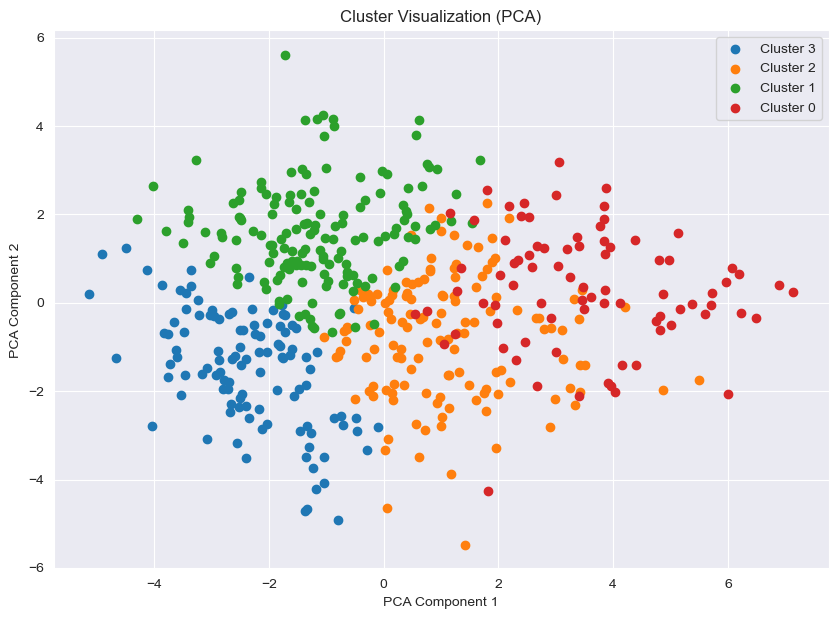

In [14]:
# Reduce data to 2 dimensions with PCA for visualization
pca = PCA(n_components=2, random_state=486)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to the dataframe for plotting
df_encoded['pca_1'] = X_pca[:, 0]
df_encoded['pca_2'] = X_pca[:, 1]

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster_id in df_encoded['cluster'].unique():
    cluster_data = df_encoded[df_encoded['cluster'] == cluster_id]
    plt.scatter(cluster_data['pca_1'], cluster_data['pca_2'], label=f"Cluster {cluster_id}")

plt.title("Cluster Visualization (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

The clusters don't seem very seperated, so we're going to try to use UMAP.

C:\Users\rache\miniconda3\envs\S486\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


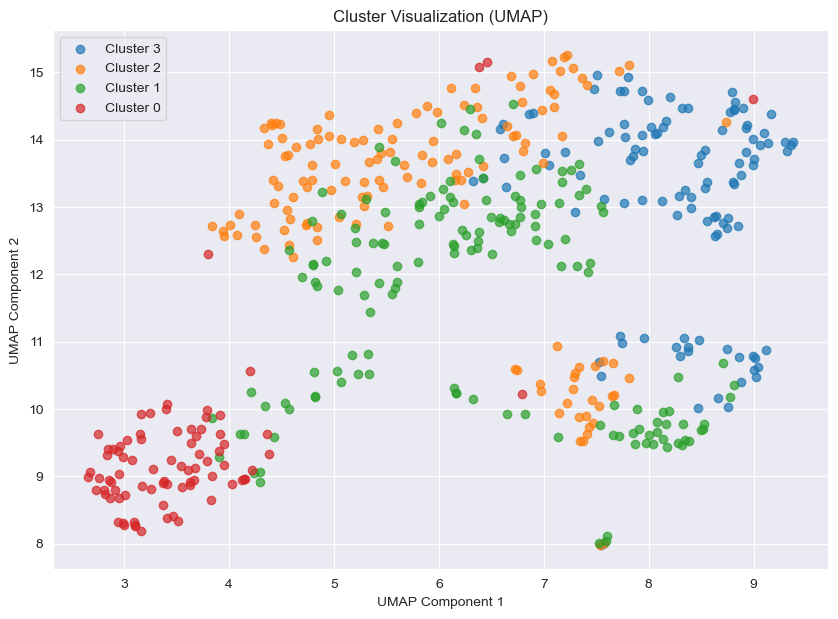

In [15]:
# Reduce data to 2 dimensions using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=486)
X_umap = umap_reducer.fit_transform(X_scaled)

# Add UMAP components to the dataframe for plotting
df_encoded['umap_1'] = X_umap[:, 0]
df_encoded['umap_2'] = X_umap[:, 1]
df_encoded.drop('timestamp', inplace=True, axis=1)

# Plot clusters
plt.figure(figsize=(10, 7))
for cluster_id in df_encoded['cluster'].unique():
    cluster_data = df_encoded[df_encoded['cluster'] == cluster_id]
    plt.scatter(cluster_data['umap_1'], cluster_data['umap_2'], label=f"Cluster {cluster_id}", alpha=0.7)

plt.title("Cluster Visualization (UMAP)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.grid(True)
plt.show()


After using UMAP, it's clear the previously predicted clusters aren't super similar to the kmeans clusters, so we'll try another clustering algorithm.

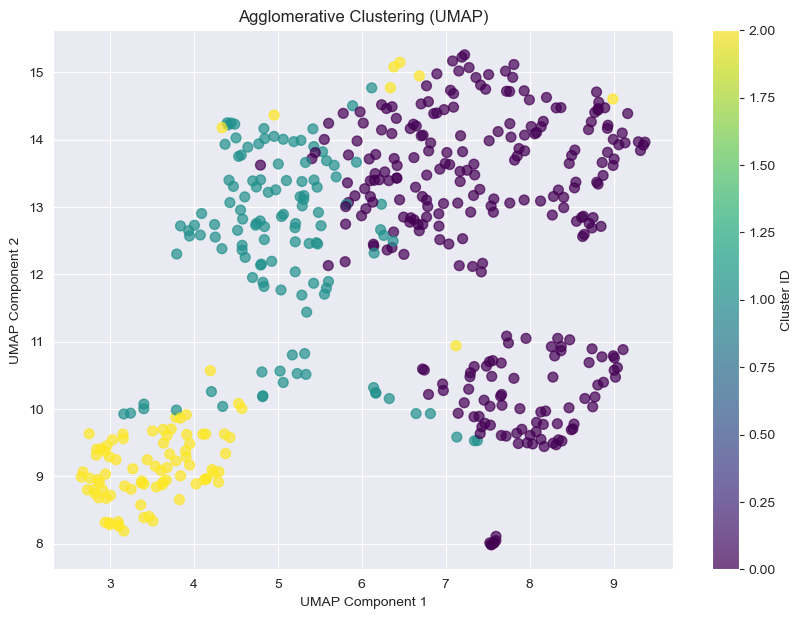

In [16]:
# Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=3)
df_encoded['agg_cluster'] = agg_clust.fit_predict(X_scaled)

# Plot Agglomerative Clustering results
plt.figure(figsize=(10, 7))
plt.scatter(df_encoded['umap_1'], df_encoded['umap_2'], c=df_encoded['agg_cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title("Agglomerative Clustering (UMAP)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()


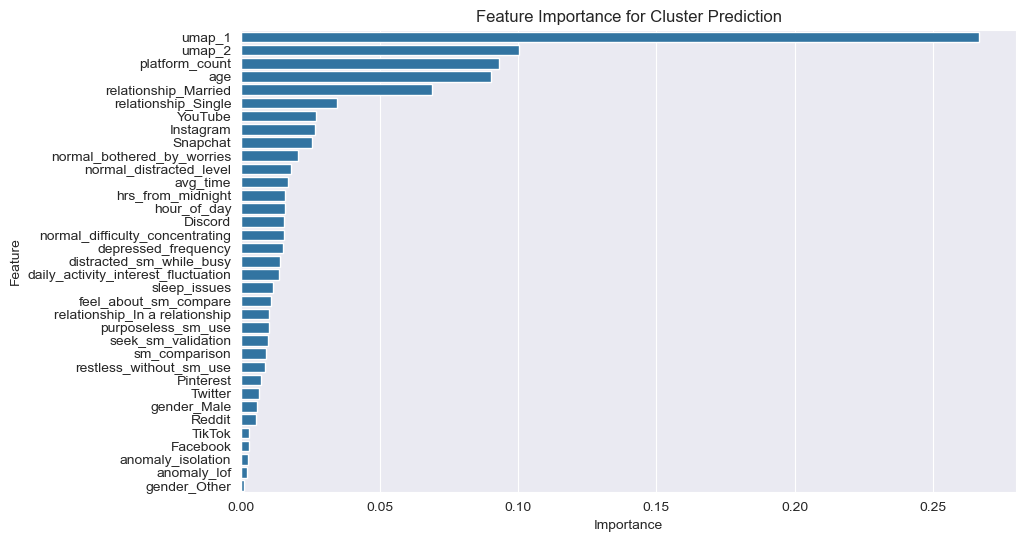

                                Feature  Importance
33                               umap_1    0.266622
34                               umap_2    0.100521
25                       platform_count    0.093255
0                                   age    0.090227
29                 relationship_Married    0.068908
30                  relationship_Single    0.034758
24                              YouTube    0.026952
18                            Instagram    0.026772
21                             Snapchat    0.025670
6            normal_bothered_by_worries    0.020489
5               normal_distracted_level    0.018165
1                              avg_time    0.017070
15                    hrs_from_midnight    0.015949
14                          hour_of_day    0.015694
16                              Discord    0.015402
7       normal_difficulty_concentrating    0.015346
11                  depressed_frequency    0.015015
3              distracted_sm_while_busy    0.014205
12  daily_ac

In [17]:
X = df_encoded.drop(columns=['agg_cluster', 'depressed_category', 'pca_1', 'pca_2', 'cluster'])

# Target variable: 'agg_cluster' (the cluster labels)
y = df_encoded['agg_cluster']

# Train a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=486)
rf.fit(X, y)

# Get the feature importance
feature_importance = rf.feature_importances_

# Create a DataFrame to hold the feature names and their importance scores
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Cluster Prediction')
plt.show()

# Show the feature importance scores
print(importance_df)

In [18]:
# Group the data by the cluster labels and calculate summary statistics
cluster_summary = df_encoded.groupby('agg_cluster').agg(
    count=('agg_cluster', 'size'),
    mean_age=('age', 'mean'),
    std_age=('age', 'std'),
    mean_ig=('Instagram', 'mean'),
    mean_yt=('YouTube', 'mean'),
    mean_sc=('Snapchat', 'mean'),
    mean_platform_count=('platform_count', 'mean'),
    mean_married=('relationship_Married', 'mean'),
    mean_purpose_sm_use=('purposeless_sm_use', 'mean'),
    mean_depressed_frequency=('depressed_frequency', 'mean'),
    mean_sleep_issues=('sleep_issues', 'mean'),
    mean_avg_time=('avg_time', "mean")
)

# Show the summaries
print("Cluster Summary (Mean and Count):")
print(cluster_summary)

Cluster Summary (Mean and Count):
             count   mean_age    std_age   mean_ig   mean_yt   mean_sc  \
agg_cluster                                                              
0              271  22.103321   4.164714  0.937269  0.970480  0.586716   
1              120  24.025000   8.445040  0.525000  0.608333  0.100000   
2               90  41.088889  10.029893  0.466667  0.844444  0.111111   

             mean_platform_count  mean_married  mean_purpose_sm_use  \
agg_cluster                                                           
0                       5.380074      0.014760             3.752768   
1                       2.633333      0.141667             3.558333   
2                       3.100000      0.888889             2.944444   

             mean_depressed_frequency  mean_sleep_issues  mean_avg_time  
agg_cluster                                                              
0                            3.667897           3.479705       3.413284  
1                

From our feature importance extraction, we can roughly sort our clusters into three groups: young (22) unmarried people who are using Instagram AND Youtube, an average of 5 different social media platforms with almost 3.5 hours of social media use a day, and generally feel their social media use is purposeless. These people have the highest risk of frequently feeling depressed. The next less depressed group is slightly different, having only half of the social media platforms, with a 50% change of using Instagram and/or Youtube, and use social media almost 40 minutes fewer a day. Our last group is older (41, but with a high standard deviation), and they're most likely married. They use social media for half the time of the second group, feel more purposeful about it, and generally use Youtube. They feel depressed by far the least frequently.

In [19]:
# Assuming `df` contains your dataset
# Target variable: depressed_frequency
X = df_encoded.drop(columns=['depressed_frequency', 'depressed_category', 'anomaly_isolation', 'anomaly_lof', 'cluster', 'agg_cluster'])
y = df_encoded['depressed_frequency']

# One-hot encoding for categorical features (if applicable)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=486)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)

Epoch 1/30
12/12 [==============================] - 1s 28ms/step - loss: 12.7466 - mae: 3.3066 - val_loss: 11.0872 - val_mae: 3.0930
Epoch 2/30
12/12 [==============================] - 0s 4ms/step - loss: 10.6524 - mae: 2.9768 - val_loss: 9.4772 - val_mae: 2.8247
Epoch 3/30
12/12 [==============================] - 0s 7ms/step - loss: 8.7082 - mae: 2.6342 - val_loss: 7.0664 - val_mae: 2.3714
Epoch 4/30
12/12 [==============================] - 0s 6ms/step - loss: 5.9145 - mae: 2.1178 - val_loss: 3.9719 - val_mae: 1.6913
Epoch 5/30
12/12 [==============================] - 0s 6ms/step - loss: 3.0578 - mae: 1.4696 - val_loss: 1.7197 - val_mae: 1.0378
Epoch 6/30
12/12 [==============================] - 0s 4ms/step - loss: 1.7839 - mae: 1.1170 - val_loss: 1.3209 - val_mae: 0.9386
Epoch 7/30
12/12 [==============================] - 0s 6ms/step - loss: 1.4612 - mae: 1.0105 - val_loss: 1.0325 - val_mae: 0.8187
Epoch 8/30
12/12 [==============================] - 0s 4ms/step - loss: 1.2091 - mae: 

4/4 [==============================] - 0s 0s/step
Mean Squared Error: 1.04
R-squared: 0.32


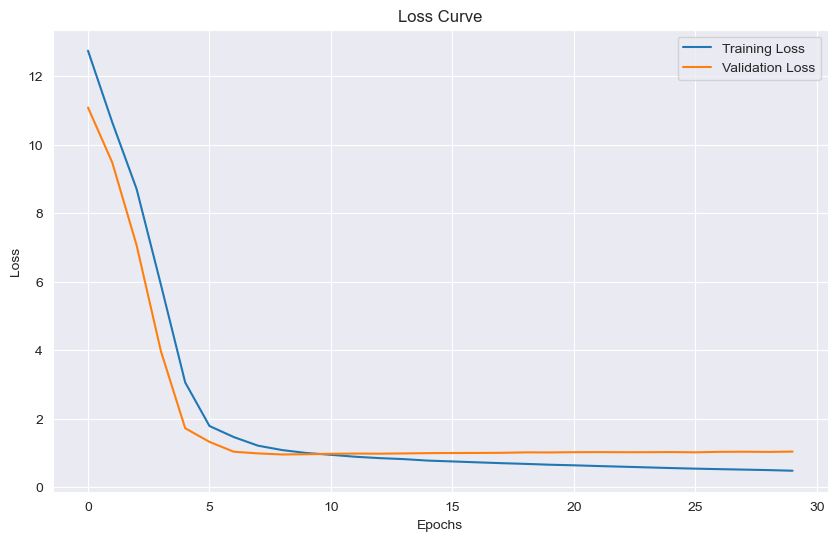

In [21]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 1.04
R-squared: 0.32
